<a href="https://colab.research.google.com/github/imn167/VAE_SS/blob/main/GoM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from function.VAE_GoM import *

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output #
import time
import openturns as ot

On teste le VAE sur une distribution gaussienne tronquée tel que les coordonnées des vecteurs soient supérieurs à un seuil.  

Pour des soucis d'efficacité et de faisabilité on choisit de tronquer seulement sur 2 coordonnées.

In [3]:
one_mode = np.load("3_component_1Side_truncated (1).npy")
d = one_mode.shape[1]

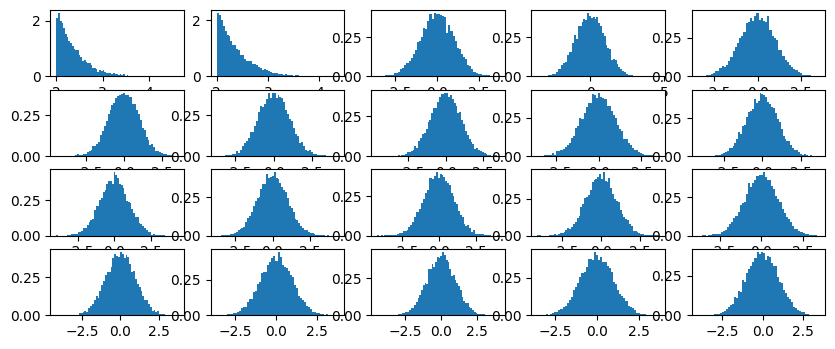

In [4]:
plt.figure(figsize=(10,5))
for i in range(d):
  plt.subplot(5,5, i+1)
  plt.hist(one_mode[:,i], density=True, bins = 'auto');

In [57]:
encoder = Encoder(d,2, True)
decoder = Decoder(d,2, True)
mixture = MoGPrior(2,6)
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001))
history = vae.fit(one_mode,epochs=110,
    batch_size=100,
    shuffle=True)

Epoch 1/110
100/100 [==============================] - 2s 2ms/step - loss: 0.0000e+00 - kl_loss: 0.5622 - reconstruction_loss: 11.1187
Epoch 2/110
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 0.5655 - reconstruction_loss: 8.6743
Epoch 3/110
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 0.4212 - reconstruction_loss: 8.1469
Epoch 4/110
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 0.3006 - reconstruction_loss: 7.8944
Epoch 5/110
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 0.2191 - reconstruction_loss: 7.8268
Epoch 6/110
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 0.2102 - reconstruction_loss: 7.8080
Epoch 7/110
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 0.1544 - reconstruction_loss: 7.7894
Epoch 8/110
100/100 [==============================] - 0s 2ms

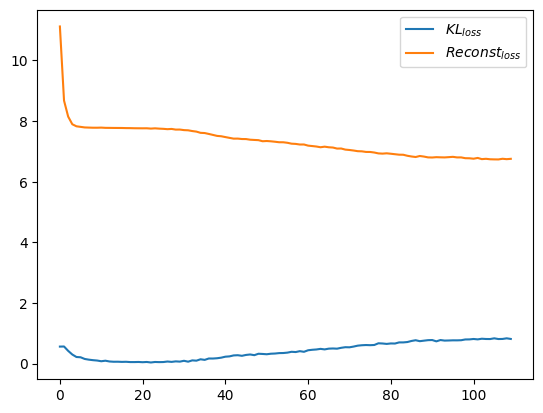

In [59]:
plt.plot(history.history['kl_loss'],  label = r'$KL_{loss}$')
plt.plot(history.history['reconstruction_loss'],   label = r'$Reconst_{loss}$')
#plt.plot(history.history['loss'], label = r'$Total_{loss}$')
plt.legend()

In [60]:
mixture.means

<tf.Variable 'means:0' shape=(6, 2) dtype=float32, numpy=
array([[-0.57014847,  1.4306192 ],
       [-1.1379402 ,  2.1389263 ],
       [-0.8371155 ,  0.673414  ],
       [ 0.0633812 ,  0.95271724],
       [-0.41070387,  0.90930885],
       [-0.19634096,  1.4038209 ]], dtype=float32)>

In [61]:
tf.exp(mixture.logvars*0.5)

<tf.Tensor: shape=(6, 2), dtype=float32, numpy=
array([[0.6682398 , 0.86026156],
       [0.74046123, 1.0582775 ],
       [0.76382923, 0.545659  ],
       [0.70262104, 0.7509436 ],
       [1.0118479 , 0.72015464],
       [0.6980259 , 0.8637087 ]], dtype=float32)>

In [62]:
weights = tf.nn.softmax(mixture.w)
weights

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.1634358 , 0.57043624, 0.04478895, 0.02814733, 0.0479902 ,
        0.1452015 ]], dtype=float32)>

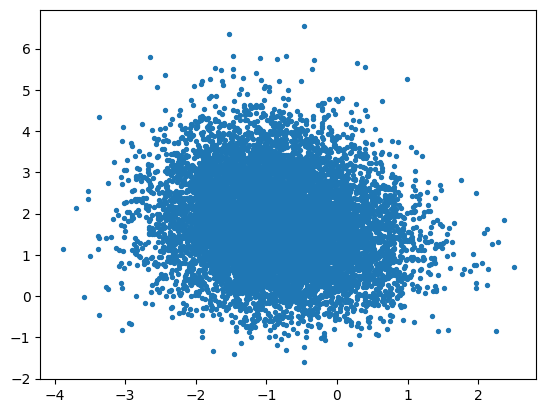

In [63]:
ColDist = [ot.Normal(np.array(mu), np.exp(0.5*np.array(sigma))) for mu, sigma in zip(mixture.means, mixture.logvars)]
weight = np.array(tf.nn.softmax(mixture.w, axis =1)).reshape(-1)
myMixture = ot.Mixture(ColDist, weight)
samples =myMixture.getSample(10000)
plt.scatter(samples[:,0], samples[:,1], s=8)

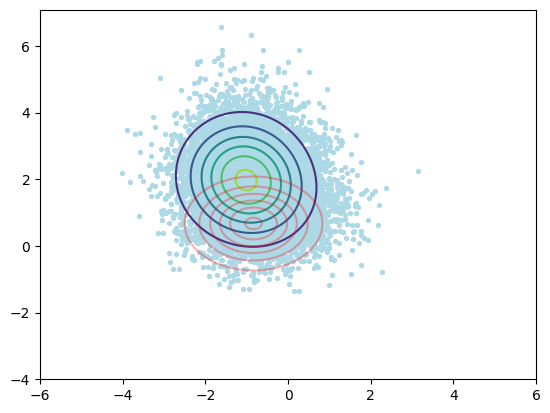

In [65]:
X, Y = np.meshgrid(np.linspace(-6,6, 1000), np.linspace(-4,6, 1000))
pos = np.dstack((X,Y))
from scipy.stats import multivariate_normal
rv1  = multivariate_normal(mixture.means[0], np.diag(tf.exp(mixture.logvars[0]*0.5))) 
rv2  = multivariate_normal(mixture.means[1], np.diag(tf.exp(mixture.logvars[1]*0.5)))
rv3  = multivariate_normal(mixture.means[2], np.diag(tf.exp(mixture.logvars[2]*0.5)))

Z    = rv1.pdf(pos) * weights[0,0] + rv2.pdf(pos) * weights[0,1] #+ rv3.pdf(pos) * weights[0,2]

plt.contour(X, Y, Z)
#plt.contour(X,Y, rv2.pdf(pos), colors = 'red', alpha = .3)
#plt.contour(X,Y, rv1.pdf(pos), colors = 'red', alpha = .3)
plt.contour(X,Y, rv3.pdf(pos), colors = 'red', alpha = .3)

_,_, z = encoder(one_mode)
plt.scatter(z[:, 0],z[:,1], s=8, c = 'lightblue');

In [ ]:
_,_, z = encoder(one_mode)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

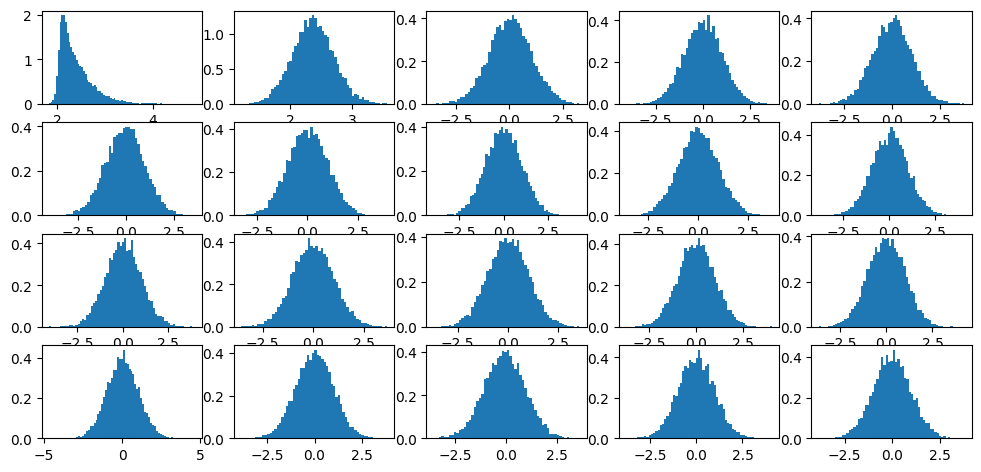

In [ ]:
plt.figure(figsize = (12,7))
for i in range(d):
  plt.subplot(5,5,i+1)
  plt.hist(sample[:,i], bins = 'auto', density=True);

Difficulté à reperer la 2e composantes 

In [109]:
encoder = Encoder(d,2, True)
decoder = Decoder(d,2, True)
ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3))
ae.fit(one_mode,epochs=200, batch_size=32, shuffle=True)

Epoch 1/200
313/313 [==============================] - 2s 2ms/step - loss: 18.6575
Epoch 2/200
313/313 [==============================] - 0s 1ms/step - loss: 16.9185
Epoch 3/200
313/313 [==============================] - 0s 1ms/step - loss: 16.3452
Epoch 4/200
313/313 [==============================] - 0s 1ms/step - loss: 15.9905
Epoch 5/200
313/313 [==============================] - 0s 2ms/step - loss: 15.8517
Epoch 6/200
313/313 [==============================] - 1s 2ms/step - loss: 15.7624
Epoch 7/200
313/313 [==============================] - 1s 2ms/step - loss: 15.6940
Epoch 8/200
313/313 [==============================] - 0s 2ms/step - loss: 15.6483
Epoch 9/200
313/313 [==============================] - 0s 2ms/step - loss: 15.5967
Epoch 10/200
313/313 [==============================] - 1s 2ms/step - loss: 15.5535
Epoch 11/200
313/313 [==============================] - 0s 2ms/step - loss: 15.5081
Epoch 12/200
313/313 [==============================] - 1s 2ms/step - loss: 15.4520
E

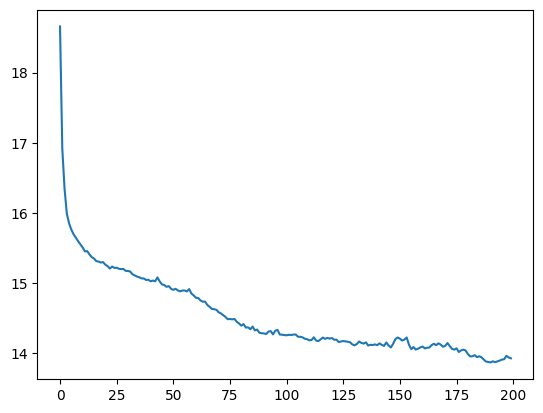

In [110]:
plt.plot(ae.history.history['loss'])

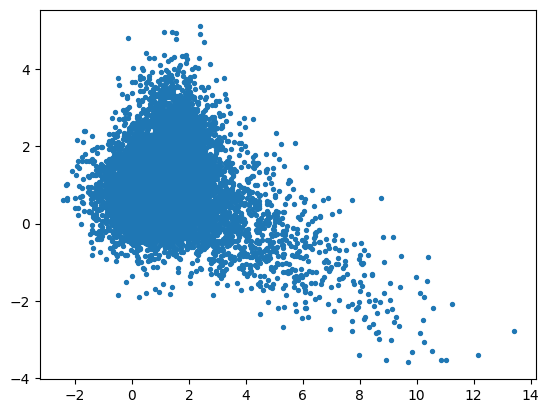

In [111]:
z_mean, _, _ = encoder(one_mode)
plt.scatter(z[:,0], z[:,1], s= 8)

In [6]:
from sklearn.decomposition import PCA

In [113]:
pca = PCA(n_components=10)
linear_latent = pca.fit_transform(one_mode)
linear_latent

array([[ 0.60735077,  0.99165289, -1.02328236, ..., -1.13788481,
        -0.13978515, -1.75545827],
       [ 0.74740937,  0.20351513, -0.81957766, ...,  0.32188663,
         0.28182003,  1.93676361],
       [ 0.53640675, -1.47969867, -2.2695578 , ..., -0.05572947,
        -0.32644121,  0.84256073],
       ...,
       [ 3.08031369, -1.48087304, -0.05574791, ...,  0.27726808,
        -0.38934078,  0.99394463],
       [ 2.13747682,  0.82287676, -0.72893248, ...,  1.9801579 ,
        -1.2342473 , -1.39566921],
       [-0.61834263, -0.48763683,  0.41403283, ..., -2.63548411,
         1.6169253 ,  0.70166329]])

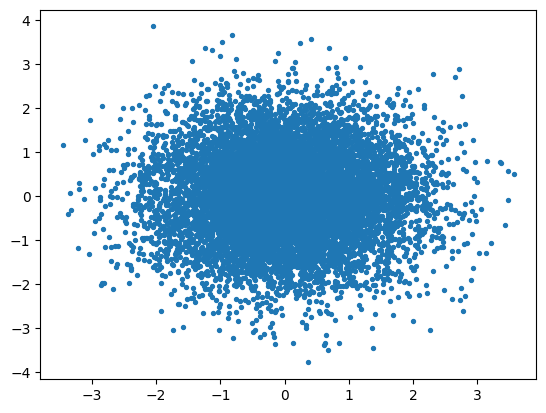

In [114]:
plt.scatter(linear_latent[:,8], linear_latent[:,9], s=8)

In [144]:
#_,_,z = encoder(one_mode)
mixture = MoGPrior(2,6)
mixture.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=.5, beta_2=.9))
mixture.fit(z, epochs=220, batch_size=64)

Epoch 1/220
157/157 [==============================] - 1s 1ms/step - loss: 4.5472
Epoch 2/220
157/157 [==============================] - 0s 1ms/step - loss: 4.4963
Epoch 3/220
157/157 [==============================] - 0s 1ms/step - loss: 4.4500
Epoch 4/220
157/157 [==============================] - 0s 1ms/step - loss: 4.3973
Epoch 5/220
157/157 [==============================] - 0s 1ms/step - loss: 4.3497
Epoch 6/220
157/157 [==============================] - 0s 1ms/step - loss: 4.3036
Epoch 7/220
157/157 [==============================] - 0s 1ms/step - loss: 4.2574
Epoch 8/220
157/157 [==============================] - 0s 1ms/step - loss: 4.2145
Epoch 9/220
157/157 [==============================] - 0s 1ms/step - loss: 4.1716
Epoch 10/220
157/157 [==============================] - 0s 1ms/step - loss: 4.1268
Epoch 11/220
157/157 [==============================] - 0s 1ms/step - loss: 4.0885
Epoch 12/220
157/157 [==============================] - 0s 1ms/step - loss: 4.0483
Epoch 13/220


In [145]:
mixture.means

<tf.Variable 'means:0' shape=(6, 2) dtype=float32, numpy=
array([[-0.90124655, -0.9426342 ],
       [-0.0360557 , -2.0584195 ],
       [-1.0122788 , -0.88730544],
       [-0.20209251, -1.5930816 ],
       [-0.51167357, -2.443565  ],
       [ 0.21011426, -0.7513064 ]], dtype=float32)>

In [146]:
tf.exp(0.5*mixture.logvars)

<tf.Tensor: shape=(6, 2), dtype=float32, numpy=
array([[1.0490644 , 0.7960004 ],
       [1.3322841 , 0.94240266],
       [1.062607  , 1.2559574 ],
       [0.71866024, 1.0049994 ],
       [1.5999919 , 1.1316406 ],
       [0.88155025, 0.8405344 ]], dtype=float32)>

In [147]:
weights = tf.nn.softmax(mixture.w)
weights

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.1249818 , 0.26178175, 0.1996905 , 0.23815686, 0.06449342,
        0.11089559]], dtype=float32)>

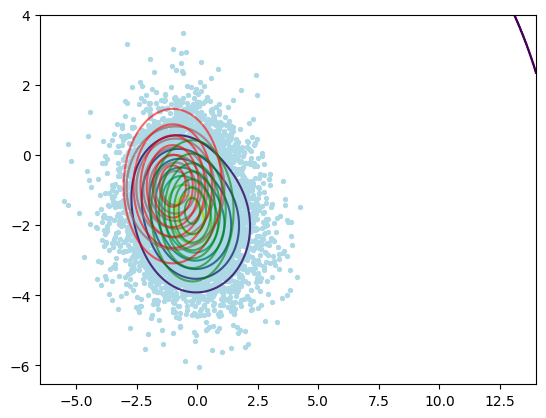

In [149]:
X, Y = np.meshgrid(np.linspace(-4,12, 1000), np.linspace(-4,4, 1000))
pos = np.dstack((X,Y))
from scipy.stats import multivariate_normal
rv1  = multivariate_normal(mixture.means[0], np.diag(tf.exp(mixture.logvars[0]*0.5))) 
rv2  = multivariate_normal(mixture.means[1], np.diag(tf.exp(mixture.logvars[1]*0.5)))
rv3  = multivariate_normal(mixture.means[2], np.diag(tf.exp(mixture.logvars[2]*0.5)))
rv4  = multivariate_normal(mixture.means[3], np.diag(tf.exp(mixture.logvars[3]*0.5)))
Z    = rv1.pdf(pos) * weights[0,0] + rv2.pdf(pos) * weights[0,1] #+ rv3.pdf(pos) * weights[0,2]

plt.contour(X, Y, Z)
plt.contour(X,Y, rv1.pdf(pos), colors = 'red', alpha = .3)
plt.contour(X,Y, rv1.pdf(pos), colors = 'gray', alpha = .6)
plt.contour(X,Y, rv3.pdf(pos), colors = 'red', alpha = .6)
plt.contour(X,Y, rv4.pdf(pos), colors = 'green', alpha = .6)
_,_, z = encoder(one_mode)
plt.scatter(z[:, 0], z[:,1], s=8, c = 'lightblue');

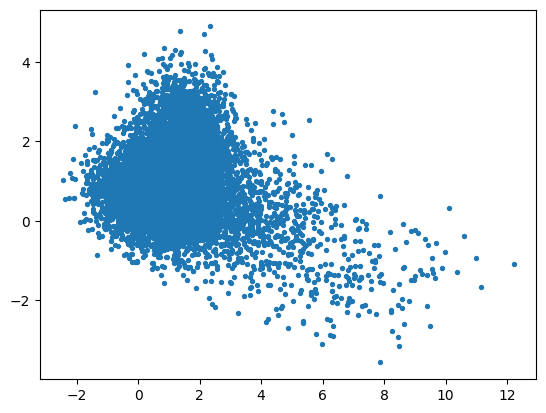

In [97]:
ColDist = [ot.Normal(np.array(mu), np.exp(0.5*np.array(sigma))) for mu, sigma in zip(mixture.means, mixture.logvars)]
weight = np.array(tf.nn.softmax(mixture.w, axis =1)).reshape(-1)
myMixture = ot.Mixture(ColDist, weight)
samples =myMixture.getSample(10000)
plt.scatter(samples[:,0], samples[:,1], s=8)


In [153]:

vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001))
history = vae.fit(one_mode,epochs=100,
    batch_size=128,
    shuffle=True)

Epoch 1/100
79/79 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - kl_loss: -0.0082 - reconstruction_loss: 7.7896
Epoch 2/100
79/79 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: -0.0012 - reconstruction_loss: 7.7802
Epoch 3/100
79/79 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 0.0153 - reconstruction_loss: 7.7941
Epoch 4/100
79/79 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: -0.0097 - reconstruction_loss: 7.7879
Epoch 5/100
79/79 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 0.0029 - reconstruction_loss: 7.7846
Epoch 6/100
79/79 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: -0.0086 - reconstruction_loss: 7.8215
Epoch 7/100
79/79 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: -0.0027 - reconstruction_loss: 7.7798
Epoch 8/100
79/79 [==============================] - 0s 2ms/step - loss

In [3]:
two_mode = np.load('2_component_truncated.npy')
d = two_mode.shape[1]
d

20

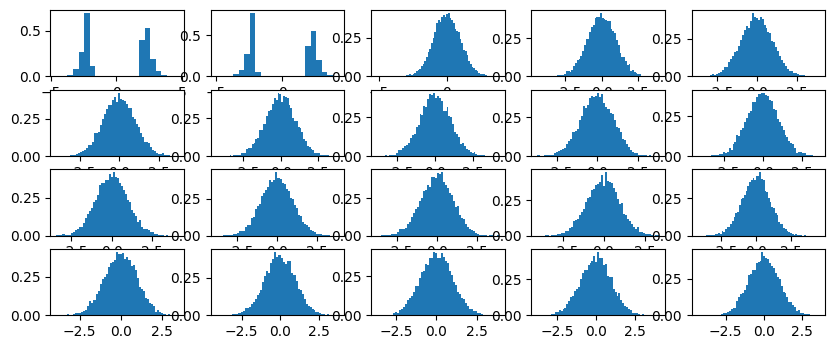

In [4]:
plt.figure(figsize=(10,5))
for i in range(d):
  plt.subplot(5,5, i+1)
  plt.hist(two_mode[:,i], density=True, bins = 'auto');

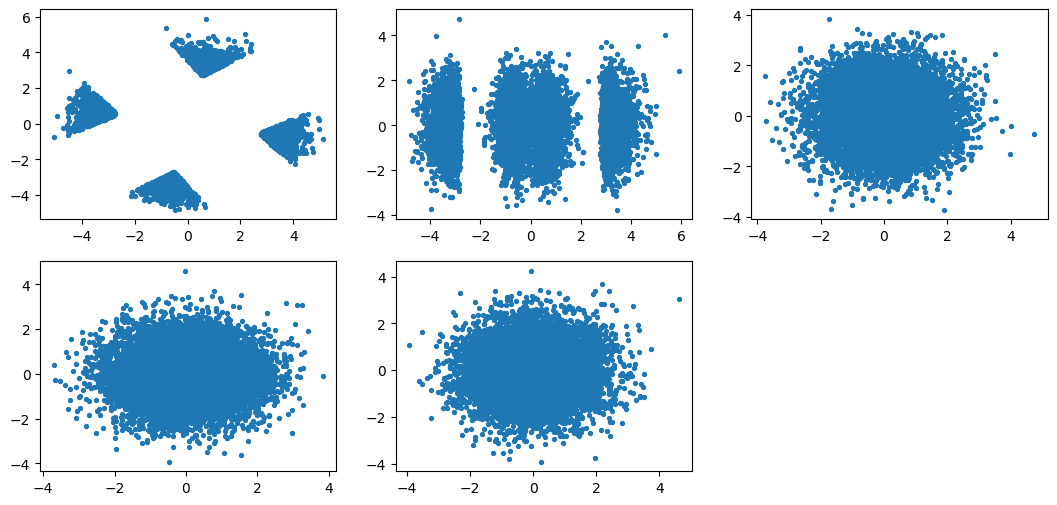

In [7]:
pca = PCA(n_components=10)
two_mode_pca = pca.fit_transform(two_mode)
plt.figure(figsize=(13,6))
for i in range(5):
    plt.subplot(2,3, i+1)
    plt.scatter(two_mode_pca[:, i], two_mode_pca[:,i+1], s=8)

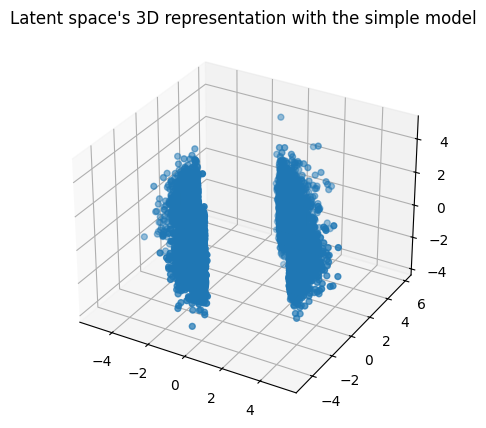

In [165]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize= (9,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(two_mode_pca[:, 0], two_mode_pca[:, 1], two_mode_pca[:, 2], s= 18);
ax.set_title("Latent space's 3D representation with the simple model");

In [58]:
encoder = Encoder(d,2, True)
decoder = Decoder(d,2, True)
ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3))
ae.fit(two_mode,epochs=70, batch_size=150, shuffle=True)

Epoch 1/70
67/67 [==============================] - 1s 2ms/step - loss: 27.7557
Epoch 2/70
67/67 [==============================] - 0s 2ms/step - loss: 24.1659
Epoch 3/70
67/67 [==============================] - 0s 2ms/step - loss: 19.0778
Epoch 4/70
67/67 [==============================] - 0s 2ms/step - loss: 18.1440
Epoch 5/70
67/67 [==============================] - 0s 2ms/step - loss: 18.0720
Epoch 6/70
67/67 [==============================] - 0s 2ms/step - loss: 17.9905
Epoch 7/70
67/67 [==============================] - 0s 2ms/step - loss: 17.8428
Epoch 8/70
67/67 [==============================] - 0s 1ms/step - loss: 17.7543
Epoch 9/70
67/67 [==============================] - 0s 2ms/step - loss: 17.6513
Epoch 10/70
67/67 [==============================] - 0s 2ms/step - loss: 17.5600
Epoch 11/70
67/67 [==============================] - 0s 3ms/step - loss: 17.4784
Epoch 12/70
67/67 [==============================] - 0s 2ms/step - loss: 17.4111
Epoch 13/70
67/67 [==================

In [59]:
z_mean, _, _ = encoder(two_mode)
z_mean

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[-12.661999 ,   2.5830255],
       [-12.58515  ,   1.5085025],
       [-11.486672 ,  -7.2810116],
       ...,
       [-11.388286 ,   1.8574282],
       [-10.093052 ,  -6.9792657],
       [-12.507162 ,   2.984132 ]], dtype=float32)>

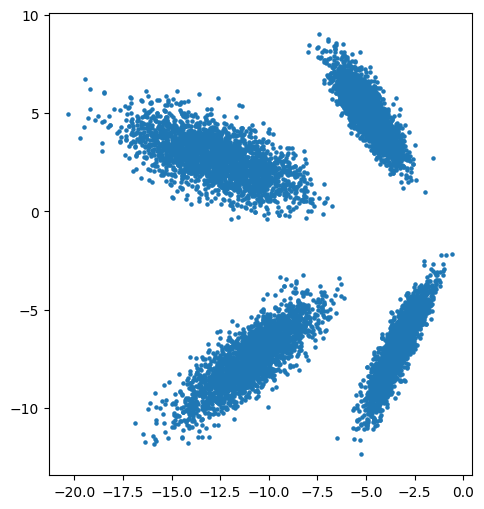

In [61]:
z_mean, _,_ = encoder(two_mode)
plt.figure(figsize=(12,6))
for i in range(1):
    plt.subplot(1,2, i+1)
    plt.scatter(z_mean[:, i], z_mean[:,i+1], s = 5)

In [73]:
#training with the pca 3 components 
mixture = MoGPrior(2,6)
mixture.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
mixture.fit(z_mean, epochs=320, batch_size=64)

Epoch 1/320
157/157 [==============================] - 1s 2ms/step - loss: 28.3499
Epoch 2/320
157/157 [==============================] - 0s 1ms/step - loss: 24.1520
Epoch 3/320
157/157 [==============================] - 0s 1ms/step - loss: 20.8420
Epoch 4/320
157/157 [==============================] - 0s 1ms/step - loss: 18.3180
Epoch 5/320
157/157 [==============================] - 0s 1ms/step - loss: 16.3377
Epoch 6/320
157/157 [==============================] - 0s 1ms/step - loss: 14.4952
Epoch 7/320
157/157 [==============================] - 0s 1ms/step - loss: 12.0277
Epoch 8/320
157/157 [==============================] - 0s 1ms/step - loss: 10.4682
Epoch 9/320
157/157 [==============================] - 0s 1ms/step - loss: 9.4768
Epoch 10/320
157/157 [==============================] - 0s 1ms/step - loss: 8.7775
Epoch 11/320
157/157 [==============================] - 0s 1ms/step - loss: 8.2500
Epoch 12/320
157/157 [==============================] - 0s 1ms/step - loss: 7.8426
Epoch

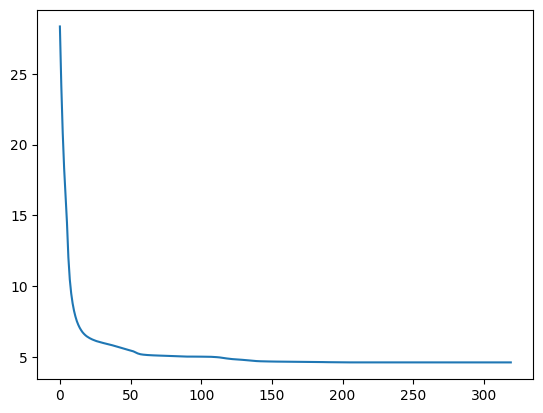

In [74]:
plt.plot(mixture.history.history['loss'])

In [75]:
mixture.means

<tf.Variable 'means:0' shape=(6, 2) dtype=float32, numpy=
array([[ -4.894453 ,   4.992391 ],
       [-11.1958065,   1.9463094],
       [ -2.9013555,  -5.944361 ],
       [-10.951716 ,  -7.5143747],
       [-14.11872  ,   3.436634 ],
       [ -4.044199 ,  -8.24665  ]], dtype=float32)>

In [76]:
tf.exp(0.5*mixture.logvars)

<tf.Tensor: shape=(6, 2), dtype=float32, numpy=
array([[0.8695011 , 1.2515785 ],
       [1.4947574 , 0.8297673 ],
       [0.55413336, 1.0105841 ],
       [1.7184283 , 1.4497205 ],
       [1.6230949 , 0.8713584 ],
       [0.4510299 , 0.96755785]], dtype=float32)>

In [77]:
weights = tf.nn.softmax(mixture.w)
weights

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.24675272, 0.12194481, 0.12930204, 0.24889918, 0.1269536 ,
        0.12614764]], dtype=float32)>

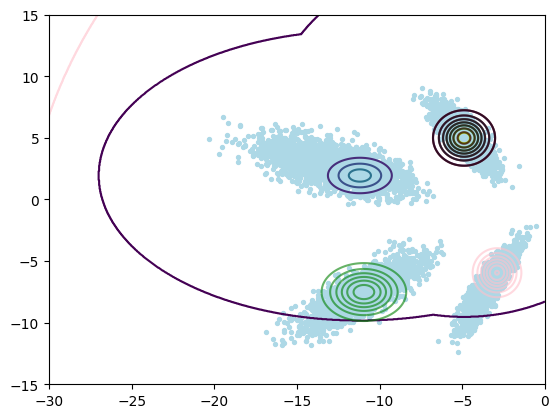

In [82]:
X, Y = np.meshgrid(np.linspace(-30,0, 1000), np.linspace(-15,15, 1000))
pos = np.dstack((X,Y))
from scipy.stats import multivariate_normal
rv1  = multivariate_normal(mixture.means[0], np.diag(tf.exp(mixture.logvars[0]*0.5))) 
rv2  = multivariate_normal(mixture.means[1], np.diag(tf.exp(mixture.logvars[1]*0.5)))
rv3  = multivariate_normal(mixture.means[2], np.diag(tf.exp(mixture.logvars[2]*0.5)))
rv4  = multivariate_normal(mixture.means[3], np.diag(tf.exp(mixture.logvars[3]*0.5)))
Z    = rv1.pdf(pos) * weights[0,0] + rv2.pdf(pos) * weights[0,1] #+ rv3.pdf(pos) * weights[0,2]

plt.contour(X, Y, Z)
plt.contour(X,Y, rv1.pdf(pos), colors = 'red', alpha = .3)
plt.contour(X,Y, rv1.pdf(pos), colors = 'black', alpha = .6)
plt.contour(X,Y, rv3.pdf(pos), colors = 'pink', alpha = .6)
plt.contour(X,Y, rv4.pdf(pos), colors = 'green', alpha = .6)
z,_, _ = encoder(two_mode)
plt.scatter(z[:, 0], z[:,1], s=8, c = 'lightblue');

In [84]:
#with only the optimisation of the prior on the 2-fist PCA axes 
enc = Encoder(d, 2, True)
dec = Decoder(d, 2, True)
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
vae.fit(two_mode, epochs = 150, batch_size = 100, shuffle = True) 

Epoch 1/150
100/100 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - kl_loss: 1.5965 - reconstruction_loss: 7.7391
Epoch 2/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.5985 - reconstruction_loss: 7.7390
Epoch 3/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.6050 - reconstruction_loss: 7.7582
Epoch 4/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.5796 - reconstruction_loss: 7.7475
Epoch 5/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.5848 - reconstruction_loss: 7.7322
Epoch 6/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.5580 - reconstruction_loss: 7.7356
Epoch 7/150
100/100 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - kl_loss: 1.5630 - reconstruction_loss: 7.7486
Epoch 8/150
100/100 [==============================] - 0s 2ms/

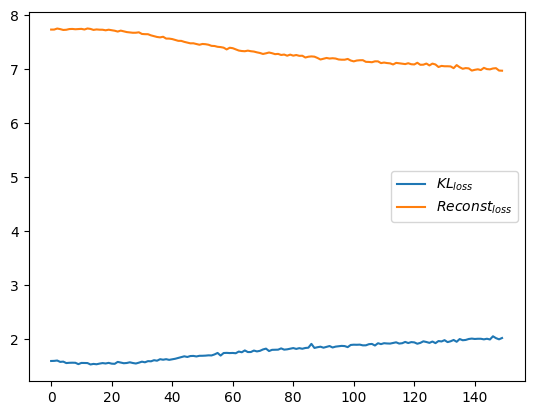

In [90]:
plt.plot(vae.history.history['kl_loss'], label = r'$KL_{loss}$')
plt.plot(vae.history.history['reconstruction_loss'], label = r'$Reconst_{loss}$')
plt.legend();

In [85]:
_,_, z = encoder(two_mode)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

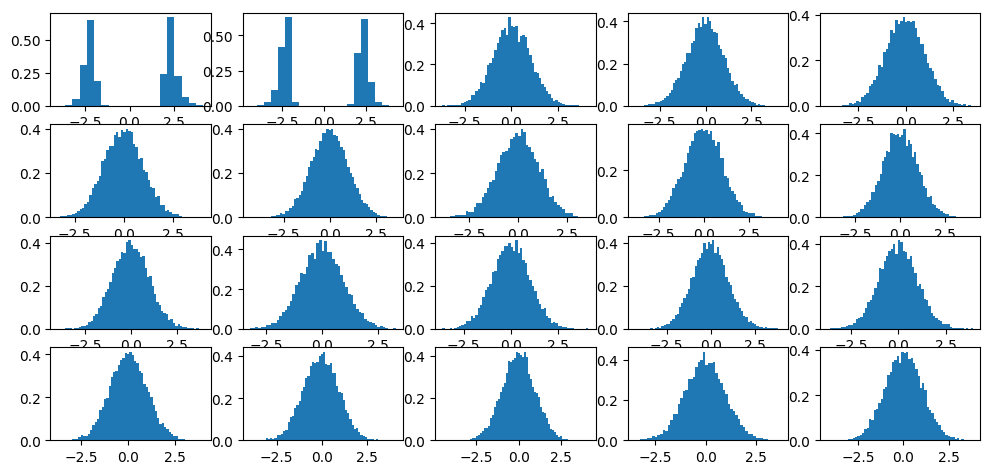

In [86]:
plt.figure(figsize = (12,7))
for i in range(d):
  plt.subplot(5,5,i+1)
  plt.hist(sample[:,i], bins = 'auto', density=True);